# アルゴリズムチェーンとパイプライン
一つのアルゴリズムを実行するだけではなく、様々な処理と複数の機械学習アルゴリズムを連鎖的に実行する => Pipelineを用いる。

スケール変換を用いた交差検証ではscalerを作るときに交差検証用のデータを除かないといけない


In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0)
scaler  = MinMaxScaler().fit(X_train,y_train)


In [4]:
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled,y_train)
X_test_scaled = scaler.transform(X_test)
print(svm.score(X_test_scaled,y_test))

0.972027972027972


In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(),param_grid=param_grid,cv=5)
grid.fit(X_train_scaled,y_train)
print(grid.best_score_)
print(grid.best_params_)
print(grid.score(X_test_scaled,y_test))

0.9812311901504789
{'C': 1, 'gamma': 1}
0.972027972027972


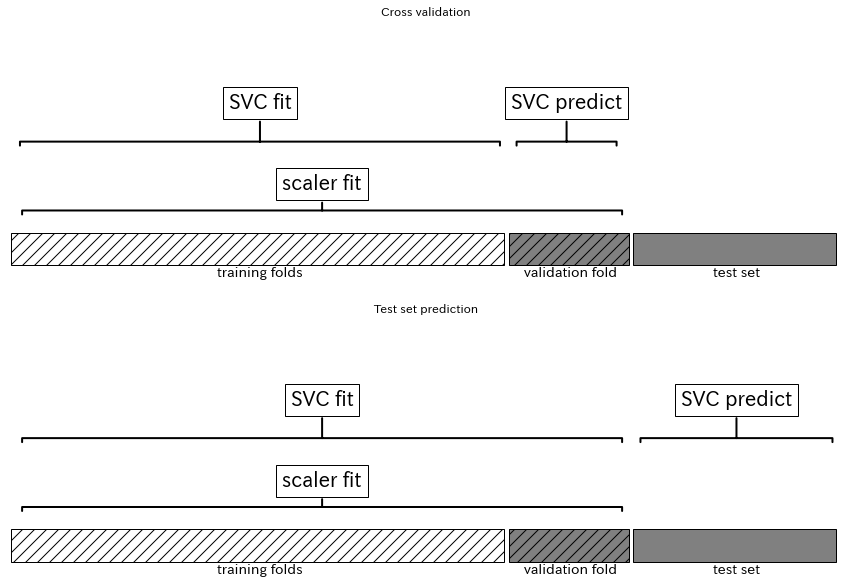

In [11]:
import mglearn
mglearn.plots.plot_improper_processing()

In [12]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler',MinMaxScaler()),('svm',SVC()) ])

In [13]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [14]:
print(pipe.score(X_test,y_test))

0.972027972027972


In [15]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [19]:
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.9812311901504789
0.972027972027972
{'svm__C': 1, 'svm__gamma': 1}


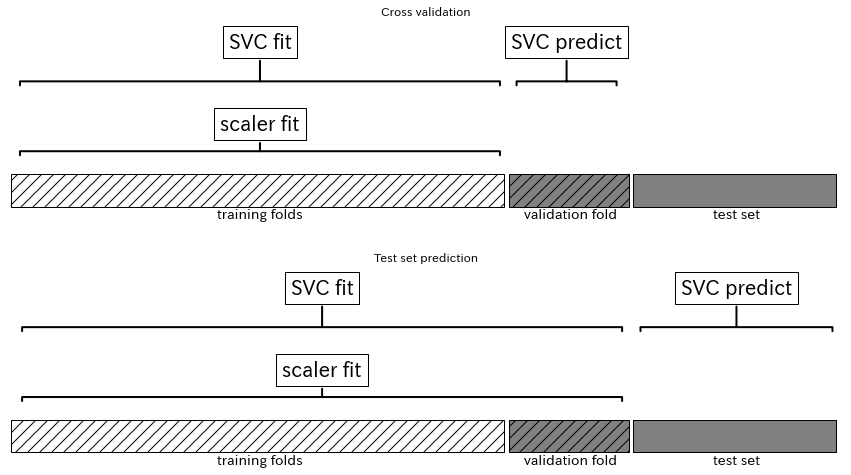

In [20]:
mglearn.plots.plot_proper_processing()

In [22]:
import numpy as np
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100,10000))
y = rnd.normal(size=(100,))

In [23]:
from sklearn.feature_selection import SelectPercentile,f_regression

select = SelectPercentile(score_func=f_regression,percentile=5).fit(X,y)
X_selected = select.transform(X)
print(X_selected.shape)

(100, 500)


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print(np.mean(cross_val_score(Ridge(),X_selected,y,cv=5)))

0.9057953065239822


In [26]:
pipe = Pipeline([('select',SelectPercentile(score_func=f_regression,percentile=5)),
                ('ridge',Ridge())])
print(np.mean(cross_val_score(pipe,X,y,cv=5)))

-0.2465542238495282


In [27]:
def fit(self,X,y):
    X_transfomed = X
    for name,estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed,y)
    self.steps[-1][1].fit(X_transformed,y)
    return self

In [28]:
def predict(self,X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    return self.steps[-1][1].predict(X_transformed)

In [29]:
from sklearn.pipeline import make_pipeline
pipe_long = Pipeline([('scaler',MinMaxScaler()),('svm',SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(),SVC(C=100))

In [31]:
print(pipe_short.steps)

[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(),PCA(n_components=2),StandardScaler())
print(pipe.steps)

[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [33]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print(components.shape)

(2, 30)


In [34]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(),LogisticRegression())

In [35]:
param_grid = {'logisticregression__C':[0.01,0.1,1,10,100]}

In [36]:
X_train,X_test,y_train,y_test = train_test_split(
cancer.data,cancer.target,random_state=4)
grid = GridSearchCV(pipe,param_grid,cv=5)


In [37]:
grid.fit(X_train,y_train)

/Users/watanabeyuitou/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/watanabeyuitou/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [40]:
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])

In [42]:
grid.best_estimator_.named_steps['logisticregression']

LogisticRegression(C=1)

In [43]:
grid.best_estimator_.named_steps['logisticregression'].coef_

array([[-0.43570655, -0.34266946, -0.40809443, -0.5344574 , -0.14971847,
         0.61034122, -0.72634347, -0.78538827,  0.03886087,  0.27497198,
        -1.29780109,  0.04926005, -0.67336941, -0.93447426, -0.13939555,
         0.45032641, -0.13009864, -0.10144273,  0.43432027,  0.71596578,
        -1.09068862, -1.09463976, -0.85183755, -1.06406198, -0.74316099,
         0.07252425, -0.82323903, -0.65321239, -0.64379499, -0.42026013]])

In [44]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train,X_test,y_train,y_test = train_test_split(boston.data,boston.target,random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())

/Users/watanabeyuitou/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Ca

In [45]:
param_grid = {'polynomialfeatures__degree':[1,2,3],
             'ridge__alpha':[0.001,0.01,0.1,1,10,100]}


In [46]:
grid = GridSearchCV(pipe,param_grid=param_grid,cv=5,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

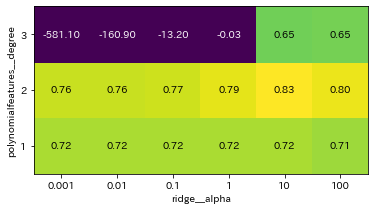

In [47]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [48]:
grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}

In [49]:
grid.score(X_test,y_test)

0.7683045464100124

In [50]:
param_grid = {'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
pipe = make_pipeline(StandardScaler(),Ridge())
grid = GridSearchCV(pipe,param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)
print(grid.score(X_test,y_test))

0.6272671927504456


In [52]:
pipe = Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())],memory="cache_folder")

In [55]:
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {'classifier':[SVC()],'preprocessing':[StandardScaler(),None],'classifier__gamma':[0.001,0.01,0.1,1,10,100],
    'classifier__C':[0.001,0.01,0.1,1,10,100]},
    {'classifier':[RandomForestClassifier()],'preprocessing':[None],
    'classifier__max_features':[1,2,3]}
    
]

In [56]:
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0)
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test,y_test))

{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}
0.9858823529411765
0.9790209790209791
